In [38]:
from glob import glob
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, Activation, Flatten, Dense, Input, MaxPooling2D
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Selecting data

In [2]:
hot_dog = glob('data/hot_dog/*')[:100]
not_hot_dog = glob('data/not_hot_dog/*')[:100]

## Preprocessing

In [8]:
ROWS = 300
COLS = 300
CHANNELS = 3
CORE = 4


def resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    with ProcessPoolExecutor(max_workers=CORE) as executor:
        data[:] = list(executor.map(resize_img, images))
    
    return data


image_hot_dog = prep_data(hot_dog)
image_not_hot_dog = prep_data(not_hot_dog)

## Preview

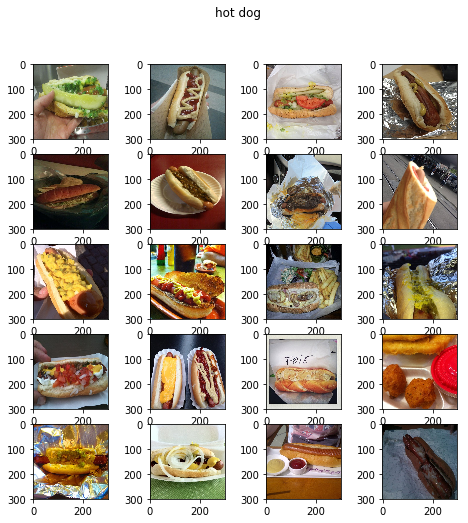

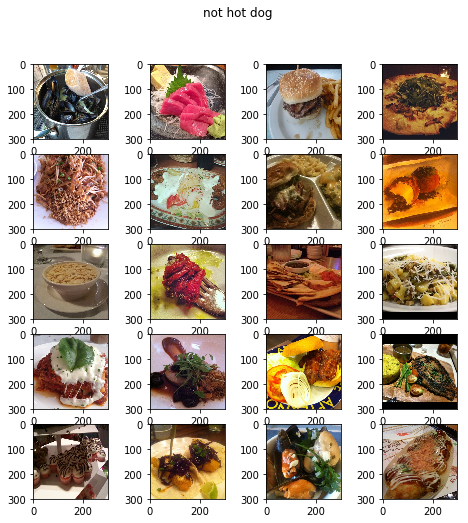

In [18]:
columns = 4
rows = 5

def preview(image, title):
    fig=plt.figure(figsize=(8, 8))
    fig.suptitle(title)
    for i in range(1, 21):
        fig.add_subplot(rows, columns, i)
        plt.imshow(cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB))

preview(image_hot_dog, 'hot dog')
preview(image_not_hot_dog, 'not hot dog')
plt.show()

## Preparing label and training data

In [32]:
x = np.concatenate((image_hot_dog, image_not_hot_dog))
y = to_categorical(np.concatenate((
    np.full(len(image_hot_dog) , 0), 
    np.full(len(image_not_hot_dog) , 1))))

# split train and test data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42, stratify=y, shuffle=True
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(134, 300, 300, 3)
(134, 2)
(66, 300, 300, 3)
(66, 2)


In [41]:
inputs = Input(shape=x_train.shape[1:])

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Classification block
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(2, activation='sigmoid', name='predictions')(x)

# Create model.
model = Model(inputs, x, name='vgg16')

# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1440000)           0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              5898244096
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total para

In [42]:
model.fit(x_train, y_train,
          epochs=10,
          batch_size=16)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.